In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Loading Data
share = 'SBIN.NS'
start_date = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2020, 7, 6)
data = yf.download(share, start_date , end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,312.450012,315.000000,310.700012,314.000000,300.547485,6138488
2015-01-02,314.350006,318.299988,314.350006,315.250000,301.743988,9935094
2015-01-05,316.250000,316.799988,312.100006,312.750000,299.351074,9136716
2015-01-06,310.000000,311.100006,298.700012,299.899994,287.051605,15329257
2015-01-07,300.000000,302.549988,295.149994,300.149994,287.290863,15046745


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-29,183.000000,183.100006,178.500000,179.250000,177.610214,50966428
2020-06-30,181.100006,182.899994,177.250000,178.449997,176.817520,43613239
2020-07-01,179.449997,185.399994,178.600006,184.800003,183.109436,54012853
2020-07-02,185.649994,188.000000,184.000000,185.449997,183.753494,52127276
2020-07-03,186.649994,186.850006,183.399994,184.699997,183.010345,38048810


In [5]:
# Preparing Data
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))
prediction_days = 80
x_train,y_train=[],[]
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
# Building Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1)) 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
40/40 [==============================] - 9s 102ms/step - loss: 0.0371
Epoch 2/30
40/40 [==============================] - 4s 102ms/step - loss: 0.0070
Epoch 3/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0056
Epoch 4/30
40/40 [==============================] - 4s 102ms/step - loss: 0.0046
Epoch 5/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0041
Epoch 6/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0035
Epoch 7/30
40/40 [==============================] - 4s 102ms/step - loss: 0.0034
Epoch 8/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0032
Epoch 9/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0034
Epoch 10/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0032
Epoch 11/30
40/40 [==============================] - 4s 102ms/step - loss: 0.0027
Epoch 12/30
40/40 [==============================] - 4s 101ms/step - loss: 0.0025
Epoch 13/30
40/40 [======

In [7]:
# Loading Test Data
test_start_date=dt.datetime(2020, 7, 7)
test_end_date=dt.datetime(2022,1,5)
test_data = yf.download(share, test_start_date , test_end_date)
actual_prices=test_data['Close'].values
total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [8]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-07,187.000000,189.199997,184.050003,188.600006,186.874680,55124494
2020-07-08,188.899994,197.449997,188.399994,191.899994,190.144485,143063102
2020-07-09,192.800003,201.000000,192.550003,199.100006,197.278625,89539723
2020-07-10,198.000000,202.500000,194.800003,195.600006,193.810638,111406477
2020-07-13,198.800003,199.800003,191.600006,192.699997,190.937164,61949761


In [9]:
test_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-29,461.00,462.149994,451.399994,454.399994,454.399994,11757303
2021-12-30,452.75,454.899994,448.500000,451.700012,451.700012,28879190
2021-12-31,454.25,461.399994,453.100006,460.450012,460.450012,10005842
2022-01-03,462.00,472.000000,460.100006,470.799988,470.799988,13124509
2022-01-04,472.50,484.700012,471.049988,483.500000,483.500000,23296671


In [10]:
# Making Predictions on Test Data
x_test,y_test=[],[]
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    y_test.append(model_inputs[x,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

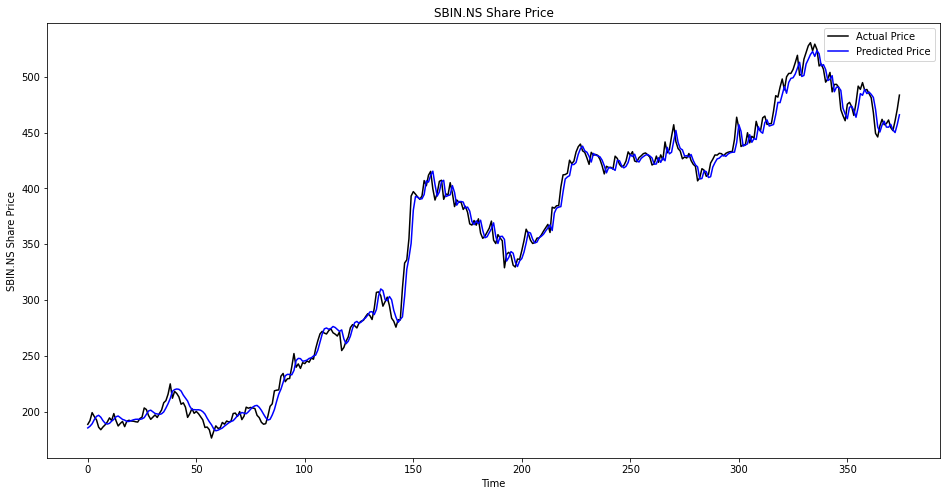

In [11]:
# Plotting the test predictions
plt.figure(figsize=(16,8))
plt.plot(actual_prices, color = "black", label=f"Actual Price")
plt.plot(predicted_prices, color="blue", label=f"Predicted Price")
plt.title(f"{share} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{share} Share Price")
plt.legend()
plt.show()

In [12]:
# Predicting Next Day
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))
prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction (next day closing price): {prediction}")

Prediction (next day closing price): [[476.19394]]


In [13]:

predicted = sm.add_constant(predicted_prices)
result = sm.OLS(y_test, predicted).fit()
print("R Square : " + str (result.rsquared*100)+" %")
print("Adjusted R Square : " + str (result.rsquared_adj*100) +" %" )

R Square : 99.45090895486895 %
Adjusted R Square : 99.44943686091416 %


In [14]:
print("Mean Absolute Error : " + str(mean_absolute_error(y_test,predicted_prices)))

Mean Absolute Error : 346.2602116061406
